In [128]:
import pandas as pd
import os

def get_dataframe(dataset_path, encoding="utf-8"):
    try:
        # List all files in the dataset directory
        files = os.listdir(dataset_path)

        # Dictionary to store DataFrames
        dataframes = {}

        # Loop through each file
        for file in files:
            file_path = os.path.join(dataset_path, file)

            # Check for .csv or .txt files
            if file.endswith(".csv"):
                data = pd.read_csv(file_path, engine='c', encoding=encoding)
                dataframes[file] = data
            elif file.endswith(".txt"):
                data = pd.read_csv(file_path, delimiter='[|\t]', engine='python', header=None, encoding=encoding)
                dataframes[file] = data
        return dataframes
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [129]:
kmrd_path = "../../kmrd-small"
dataframes = get_dataframe(kmrd_path)
print(f"{dataframes.keys()}")

dict_keys(['countries.csv', 'movies.txt', 'genres.csv', 'rates.csv', 'peoples.txt', 'castings.csv'])


In [130]:
# countries.csv 데이터프레임 불러오기
countries_df = dataframes['countries.csv']

movies_df = dataframes['movies.txt'].copy()
movies_df.columns = movies_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
movies_df = movies_df.iloc[1:]  # 첫 번째 행 제거
movies_df.reset_index(drop=True, inplace=True)

# 1. Title과 Title_eng의 결측치를 처리
# 둘 중 하나만 있는 경우, 없는 값을 다른 값으로 채움
movies_df.loc[movies_df['title'].isnull() & movies_df['title_eng'].notnull(), 'title'] = movies_df['title_eng']
movies_df.loc[movies_df['title_eng'].isnull() & movies_df['title'].notnull(), 'title_eng'] = movies_df['title']

# 둘 다 없는 경우 해당 행 제거
movies_df = movies_df.dropna(subset=['title', 'title_eng'])


# 2. Year 열의 결측치를 최빈값으로 채움
if movies_df['year'].isnull().sum() > 0:  # 결측치가 있는 경우
    most_frequent_year = movies_df['year'].mode()[0]  # 최빈값 계산
    movies_df['year'] = movies_df['year'].fillna(most_frequent_year)

# 3. Grade 열의 결측치를 'Unknown'으로 채움
movies_df['grade'] = movies_df['grade'].fillna('Unknown')

# 4. type 재설정
movies_df['movie'] = movies_df['movie'].astype(int)
movies_df['year'] = movies_df['year'].astype(int)

genres_df = dataframes['genres.csv']
rates_df = dataframes['rates.csv']

# Unix 타임스탬프를 datetime으로 변환
rates_df['time'] = pd.to_datetime(rates_df['time'], unit='s')

# peoples.txt 데이터프레임 불러오기
peoples_df = dataframes['peoples.txt'].copy()

# 첫 번째 행 제거 및 열 이름 설정
peoples_df.columns = peoples_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
peoples_df = peoples_df.iloc[1:]  # 첫 번째 행 제거

# 인덱스 재설정
peoples_df.reset_index(drop=True, inplace=True)

peoples_df['original'] = peoples_df['original'].fillna('Unknown')

# 4. type 재설정
peoples_df['people'] = peoples_df['people'].astype(int)

# castings.csv 데이터프레임 불러오기
castings_df = dataframes['castings.csv']

In [131]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS: 'AppleGothic', Windows: 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

### bar chart

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_bar_chart(df, x_column, y_column, figsize=(7, 4), title=None, xlabel=None, ylabel=None):
    """
    Draw a bar chart for grouped data.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_column (str): The name of the column for the x-axis.
        y_column (str): The name of the column for the y-axis.
        figsize (tuple): Size of the figure. Default is (7, 4).
        title (str): Title for the bar chart. Default is None.
        xlabel (str): Label for the x-axis. Default is None.
        ylabel (str): Label for the y-axis. Default is None.
    """
    plt.figure(figsize=figsize)
    sns.barplot(data=df, x=x_column, y=y_column, color="skyblue")
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    plt.xlabel(xlabel if xlabel else x_column, fontsize=12)
    plt.ylabel(ylabel if ylabel else y_column, fontsize=12)
    plt.title(title if title else f'Bar Chart of {y_column} by {x_column}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 국가별 영화 수

In [133]:
country_per_movie = (
    countries_df.groupby('country', as_index=False)
    .agg(movie_count=('movie', 'count'))
    .sort_values(by='movie_count', ascending=False)
    .query('movie_count > 1')
)

print(country_per_movie)

      country  movie_count
12         미국          654
34         한국           94
22         영국           94
32        프랑스           70
35         홍콩           51
25       이탈리아           43
9    독일(구 서독)           20
23    오스트레일리아           12
6          대만           10
18        스페인            7
26         일본            6
29        캐나다            6
27         중국            5
10  러시아(구 소련)            4
17        스웨덴            4
2   남아프리카 공화국            3
31        폴란드            3
8          독일            2
15       보츠와나            2
16        브라질            2
21        알제리            2


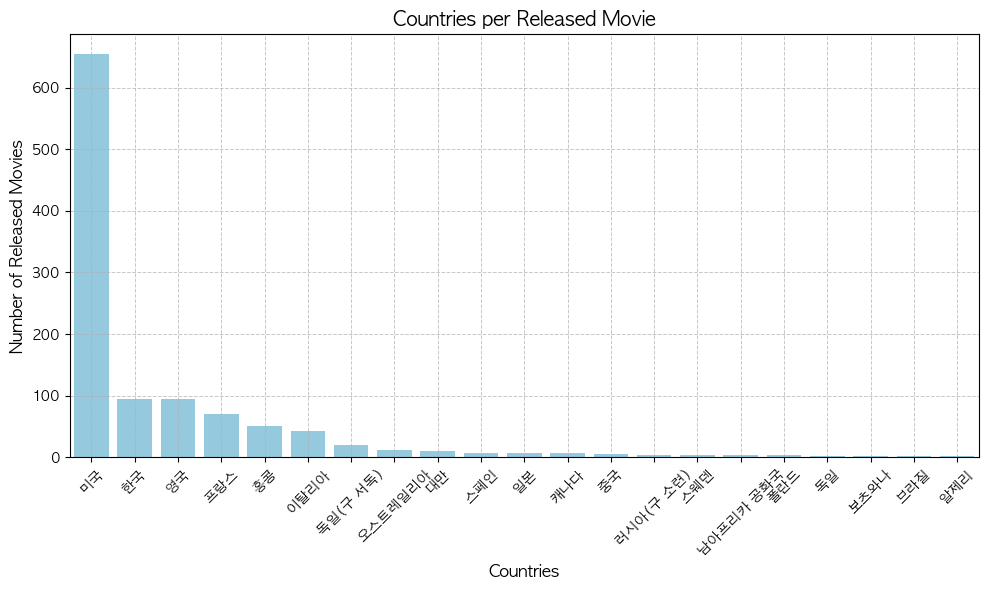

In [134]:
draw_bar_chart(
    df=country_per_movie,
    x_column='country',
    y_column='movie_count',
    title="Countries per Released Movie",
    figsize=(10, 6),
    xlabel="Countries",
    ylabel="Number of Released Movies"
)
    

# 출연배우 탐색

In [135]:
peoples_df.head(3)

,people,korean,original
0,5,아담 볼드윈,Adam Baldwin
1,8,애드리안 라인,Adrian Lyne
2,9,에이단 퀸,Aidan Quinn


In [136]:
castings_df.head(3)

,movie,people,order,leading
0,10001,4374,1,1
1,10001,178,2,1
2,10001,3241,3,1


### 가장 많은 영화에 주연으로 출연한 배우

In [229]:
leading_actors = (
    peoples_df.merge(castings_df, on='people')
    .query('leading == 1')
    .groupby(['korean'], as_index=False)
    .agg(
        leading_count=('leading', 'count'),
        original=('original', 'first')
    )
    .sort_values(by='leading_count', ascending=False)  # 주연 횟수 기준 정렬
)

# 최상위 배우 정보 추출
top_actor = leading_actors.iloc[0]
print(f"{top_actor['korean']} ({top_actor['original']}), 주연으로 {top_actor['leading_count']}회 출연")
leading_actors.head()

로버트 드 니로 (Robert De Niro), 주연으로 16회 출연


,korean,leading_count,original
290,로버트 드 니로,16,Robert De Niro
826,안성기,13,Unknown
738,숀 코네리,11,Sean Connery
786,실베스터 스탤론,11,Sylvester Stallone
1521,클린트 이스트우드,11,Clint Eastwood


- first: 첫 번째 값을 반환 (현재 사용 중).
- last: 마지막 값을 반환.
- min: 사전순 또는 숫자 값의 최소값 반환.
- max: 사전순 또는 숫자 값의 최대값 반환.
- 사용자 정의 함수: 예를 들어, 특정 조건으로 값을 처리.


people	korean	original   
1	송강호	Song KangHo   
1	송강호	KangHo Song   
2	이병헌	Lee ByungHun   

original=('original', 'first')
- 결과: "Song KangHo"
original=('original', 'last')
- 결과: "KangHo Song"

사용자 정의 함수:
original=('original', lambda x: x.iloc[0])  # 첫 번째 값
original=('original', lambda x: ' / '.join(x))  # 모든 값을 슬래시로 연결


### 가장 많은 영화에 조연으로 출연한 배우

In [230]:
actors = (
    peoples_df.merge(castings_df, on='people')
    .query('leading == 0')
    .groupby(['korean'], as_index=False)
    .agg(
        leading_count=('leading', 'count'),
        original=('original', 'first'),
    )
    .sort_values(by='leading_count', ascending=False)
)

# 최상위 배우 정보 추출
top_actor = actors.iloc[0]
print(f"{top_actor['korean']} ({top_actor['original']}), 조연으로 {top_actor['leading_count']}회 출연")
actors.head()

우마 (Wu Ma), 조연으로 9회 출연


,korean,leading_count,original
3122,우마,9,Wu Ma
1806,박예숙,7,Unknown
283,나갑성,7,Unknown
3918,조주미,6,Unknown
4150,주호성,6,Unknown


### 주연으로 출연한 영화(5편 이상 출연)들의 평균 평점이 가장 높은 영화(평점 10개 이상)의 주연 배우
- (상위 3개 영화 등 조건을 변경할 수 있게 처리)

In [170]:
movies_df.head(3)

,movie,title,title_eng,year,grade
0,10001,시네마 천국,"Cinema Paradiso , 1988",2013,전체 관람가
1,10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015,12세 관람가
2,10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015,12세 관람가


In [171]:
rates_df.head(3)

,user,movie,rate,time
0,0,10003,7,2017-05-07 03:34:00
1,0,10004,7,2016-07-03 07:10:00
2,0,10018,9,2017-12-15 13:22:00


In [222]:
best_actors = (
    peoples_df.merge(castings_df, on='people')
    .query('leading == 1')
    .groupby('korean', as_index=False)
    .agg(
        leading_count=('leading', 'count'),
        movies=('movie', list)
    )
    .query('leading_count >= 5')
)
best_actors.head(3)

,korean,leading_count,movies
17,강수연,5,"[10134, 10421, 10468, 10837, 10921]"
18,강신성일,7,"[10063, 10199, 10271, 10446, 10567, 10846, 10937]"
30,골디 혼,6,"[10139, 10206, 10339, 10961, 10965, 10996]"


In [223]:
best_movies = (
    movies_df.merge(rates_df, on="movie")
    .groupby('movie', as_index=False)
    .agg(
        mean_rate=('rate', 'mean'),
        rate_count=('rate', 'count')
    )
    .query('rate_count >= 10')
)
best_movies.head(3)

,movie,mean_rate,rate_count
0,10001,9.294360,3635
1,10002,9.416778,3004
2,10003,9.270981,989


In [224]:
top_n = 3
top_actors = (
    best_actors.explode('movies')
    .merge(best_movies[['movie', 'mean_rate']], left_on='movies', right_on='movie', how='left')
    .groupby(['korean'], as_index=False)
    .agg(
        mean_rate=('mean_rate', 'mean')
    )
    .nlargest(top_n, 'mean_rate')
)

print(f"평균 평점이 높은 상위 {top_n}명의 배우:")
print(top_actors)

평균 평점이 높은 상위 3명의 배우:
    korean  mean_rate
72  찰리 채플린   9.302453
6   다이안 키튼   9.208945
50     안정국   9.098039


- explode : 리스트를 행으로 분리
  
best_actors (before explode):   
korean	movies   
배우 A	[10134, 10421, 10468]   
배우 B	[10176, 10234]

best_actors.explode('movies') (after explode):   
korean	movies   
배우 A	10134   
배우 A	10421   
배우 A	10468  
배우 B	10176  
배우 B	10234  

- merge(best_movies[['movie', 'mean_rate']], left_on='movies', right_on='movie', how='left')  
: best_actors 데이터프레임의 각 movies(영화 ID)에 대해 best_movies 데이터프레임에서 해당 영화의 mean_rate(평균 평점)를 병합

- best_movies[['movie', 'mean_rate']]: best_movies의 두 열을 선택
- left_on='movies': best_actors의 movies 열을 기준으로 병합.
- right_on='movie': best_movies의 movie 열을 기준으로 병합.
- how='left': best_actors의 모든 행을 유지하며, 매칭되지 않는 movie는 NaN으로 남김.


best_movies[['movie', 'mean_rate']]:   
movie	mean_rate  
10134	9.1  
10421	8.5  
10176	9.7  
  
korean	movies	mean_rate  
배우 A	10134	9.1  
배우 A	10421	8.5  
배우 A	10468	NaN  
배우 B	10176	9.7  
배우 B	10234	NaN  


- nlargest / nsmallest sort_values + 슬라이싱보다 효율적으로 값을 찾을 수 있음
- idxmax / idxmin : 지정된 열의 값이 가장 큰 또는 가장 작은 행의 인덱스를 반환.